# Influence functions for data mis-labelling

Both data mis-labelling and outlier detection target the same problem, they are operating on discrete and continuous values, respectively. A influence function $I(x_1, x_2) \colon \mathbb{R}^n \times \mathbb{R}^n \to \mathbb{R} $ measures the influence of the data point $x_1$ onto $x_2$ conditioned on the training targets $y_1$ and $y_2$. As long as the loss function $L(x, y)$ is differentiable (or can be approximated by a surrogate objective). Imagine a simple classification problem, where $y_i \in \{1, \dots, K\}$, the goal is now to find labels which are mislabelled. In our case we further simplify the problem to set $K=2$.

## Artificial data generation

First we generate a K-class, M-dimensional dataset using a Gaussian mixture model (GMM). This can be done by sampling $N$ data points from a discrete distribution with $K$ different values. For each of these different discrete states a mean is specified and the observation $x$ is sampled accordingly.

In [31]:
from valuation.utils import Dataset
from sklearn.model_selection import train_test_split

import numpy as np

N = 1000
K = 2
M = 2
sigma = 0.2

gaussian_mean = np.asarray([
    [0.0, 0.0],
    [1.0, 1.0]
])
gaussian_cov = sigma * np.eye(M)
gaussian_chol = np.linalg.cholesky(gaussian_cov)
y = np.random.randint(K, size=N)
x = np.einsum('ij,kj->ki', gaussian_chol, np.random.normal(size=[N, M])) + gaussian_mean[y]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.70)
dataset = Dataset(
    x_train,
    y_train,
    x_test,
    y_test
)

## Inspecting the dataset

It is always helpful to visualize the dataset, in the 2-dimensional case it is rather straight forward and we just choose one color for each class. Note that both the train and test set are plotted separately.

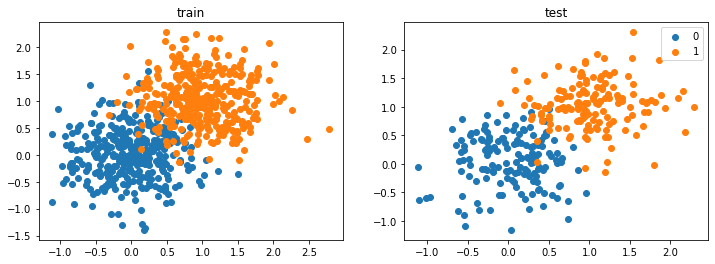

In [32]:
import matplotlib.pyplot as plt

datasets = {
    'train': (dataset.x_train, dataset.y_train),
    'test': (dataset.x_test, dataset.y_test)
}
num_datasets = len(datasets)
fig, ax = plt.subplots(1, num_datasets, figsize=(12, 4))

for i, dataset_name in enumerate(datasets.keys()):
    x, y = datasets[dataset_name]
    ax[i].set_title(dataset_name)

    for v in np.unique(y):
        idx = np.argwhere(y == v)
        ax[i].scatter(x[idx, 0], x[idx, 1], label=str(v))


plt.legend()
plt.show()

As one can see the two classes slighlty overlap and we expect sampples from this region to have higher influence on the remaining region. We are going to verify this in the next section.

## Calculating linear influences using logistic regression

For calculating the influences his section we utilize a logistic regression model to identify wrongly labelled data samples. As a first step one needs to define a model, fit it to the data and then insert it in the influence function

In [45]:
from valuation.models.pytorch_model import PyTorchSupervisedModel, PyTorchOptimizer
from valuation.influence.general import influences
from valuation.influence.types import InfluenceTypes
from valuation.models.binary_logistic_regression import BinaryLogisticRegressionTorchModel
import torch.nn.functional as F

objective = F.binary_cross_entropy
model = PyTorchSupervisedModel(
    model=BinaryLogisticRegressionTorchModel(M),
    objective=F.binary_cross_entropy,
    num_epochs=1000,
    batch_size=128,
    optimizer=PyTorchOptimizer.ADAM_W,
    optimizer_kwargs={"lr": 0.01, "weight_decay": 0.005},
)
model.fit(
    dataset.x_train,
    dataset.y_train
)

train_influences = influences(
    model,
    dataset.x_train,
    dataset.y_train,
    dataset.x_test,
    dataset.y_test,
    influence_type=InfluenceTypes.Up
)
test_influences = influences(
    model,
    dataset.x_test,
    dataset.y_test,
    influence_type=InfluenceTypes.Up
)

Training loss: 0.6815316081047058
Training loss: 0.676590085029602
Training loss: 0.6707318425178528
Training loss: 0.6682228446006775
Training loss: 0.6666683554649353
Training loss: 0.6563339829444885
Training loss: 0.6516827344894409
Training loss: 0.6449604034423828
Training loss: 0.6392314434051514
Training loss: 0.6432530283927917
Training loss: 0.6444418430328369
Training loss: 0.6283578276634216
Training loss: 0.6242390871047974
Training loss: 0.6167059540748596
Training loss: 0.61075359582901
Training loss: 0.6195283532142639
Training loss: 0.6226183772087097
Training loss: 0.6024244427680969
Training loss: 0.5985198020935059
Training loss: 0.590679407119751
Training loss: 0.5844956040382385
Training loss: 0.5969411134719849
Training loss: 0.6013875007629395
Training loss: 0.5782753229141235
Training loss: 0.5743587017059326
Training loss: 0.5665490031242371
Training loss: 0.5601653456687927
Training loss: 0.5754712224006653
Training loss: 0.5809211134910583
Training loss: 0.5

Training loss: 0.19067606329917908
Training loss: 0.20095707476139069
Training loss: 0.20430496335029602
Training loss: 0.23126791417598724
Training loss: 0.21309219300746918
Training loss: 0.18692028522491455
Training loss: 0.1893593817949295
Training loss: 0.19994068145751953
Training loss: 0.2029082030057907
Training loss: 0.23003767430782318
Training loss: 0.21195100247859955
Training loss: 0.18559899926185608
Training loss: 0.1880768984556198
Training loss: 0.19895631074905396
Training loss: 0.2015470266342163
Training loss: 0.22884082794189453
Training loss: 0.21084029972553253
Training loss: 0.18431106209754944
Training loss: 0.1868274211883545
Training loss: 0.1980026662349701
Training loss: 0.20022007822990417
Training loss: 0.22767609357833862
Training loss: 0.20975899696350098
Training loss: 0.18305520713329315
Training loss: 0.18560968339443207
Training loss: 0.19707858562469482
Training loss: 0.1989261507987976
Training loss: 0.2265423685312271
Training loss: 0.20870599150

Training loss: 0.17299465835094452
Training loss: 0.1386936604976654
Training loss: 0.1433301717042923
Training loss: 0.1699329912662506
Training loss: 0.15328550338745117
Training loss: 0.1889227330684662
Training loss: 0.1727042943239212
Training loss: 0.13832350075244904
Training loss: 0.14298801124095917
Training loss: 0.1697750687599182
Training loss: 0.15290567278862
Training loss: 0.18864428997039795
Training loss: 0.17241840064525604
Training loss: 0.13795851171016693
Training loss: 0.14265091717243195
Training loss: 0.1696210503578186
Training loss: 0.1525311917066574
Training loss: 0.18837077915668488
Training loss: 0.17213687300682068
Training loss: 0.13759860396385193
Training loss: 0.14231882989406586
Training loss: 0.1694709062576294
Training loss: 0.15216192603111267
Training loss: 0.18810206651687622
Training loss: 0.17185965180397034
Training loss: 0.13724368810653687
Training loss: 0.14199160039424896
Training loss: 0.16932448744773865
Training loss: 0.151797801256179

Training loss: 0.16502659022808075
Training loss: 0.13618901371955872
Training loss: 0.17769214510917664
Training loss: 0.16034112870693207
Training loss: 0.12187040597200394
Training loss: 0.12817884981632233
Training loss: 0.16500647366046906
Training loss: 0.13601571321487427
Training loss: 0.1775962859392166
Training loss: 0.16022340953350067
Training loss: 0.12170363962650299
Training loss: 0.1280340999364853
Training loss: 0.16498734056949615
Training loss: 0.1358441561460495
Training loss: 0.1775018721818924
Training loss: 0.1601070612668991
Training loss: 0.12153855711221695
Training loss: 0.127890944480896
Training loss: 0.16496914625167847
Training loss: 0.13567429780960083
Training loss: 0.1774088740348816
Training loss: 0.15999214351177216
Training loss: 0.12137512862682343
Training loss: 0.12774938344955444
Training loss: 0.1649518758058548
Training loss: 0.13550615310668945
Training loss: 0.177317276597023
Training loss: 0.15987852215766907
Training loss: 0.12121335417032

Training loss: 0.17358984053134918
Training loss: 0.15481019020080566
Training loss: 0.11355319619178772
Training loss: 0.12116988748311996
Training loss: 0.1651441901922226
Training loss: 0.12743155658245087
Training loss: 0.17355406284332275
Training loss: 0.1547548621892929
Training loss: 0.11346245557069778
Training loss: 0.12109629064798355
Training loss: 0.16516026854515076
Training loss: 0.1273374706506729
Training loss: 0.1735188364982605
Training loss: 0.15470005571842194
Training loss: 0.11337243765592575
Training loss: 0.12102334946393967
Training loss: 0.16517658531665802
Training loss: 0.12724412977695465
Training loss: 0.17348408699035645
Training loss: 0.1546458899974823
Training loss: 0.11328315734863281
Training loss: 0.1209511011838913
Training loss: 0.165193110704422
Training loss: 0.12715157866477966
Training loss: 0.17344993352890015
Training loss: 0.15459223091602325
Training loss: 0.11319461464881897
Training loss: 0.12087948620319366
Training loss: 0.16520991921

Training loss: 0.12271656841039658
Training loss: 0.17210404574871063
Training loss: 0.15221574902534485
Training loss: 0.10896535962820053
Training loss: 0.11755694448947906
Training loss: 0.16648073494434357
Training loss: 0.12265792489051819
Training loss: 0.17209050059318542
Training loss: 0.15218721330165863
Training loss: 0.10890965163707733
Training loss: 0.11751461029052734
Training loss: 0.16650432348251343
Training loss: 0.12259969115257263
Training loss: 0.17207716405391693
Training loss: 0.15215906500816345
Training loss: 0.10885433852672577
Training loss: 0.11747262626886368
Training loss: 0.16652797162532806
Training loss: 0.1225418895483017
Training loss: 0.17206409573554993
Training loss: 0.152131125330925
Training loss: 0.10879941284656525
Training loss: 0.11743097007274628
Training loss: 0.1665516346693039
Training loss: 0.12248443812131882
Training loss: 0.17205116152763367
Training loss: 0.1521034687757492
Training loss: 0.10874487459659576
Training loss: 0.11738971

Training loss: 0.10611000657081604
Training loss: 0.11545110493898392
Training loss: 0.16796675324440002
Training loss: 0.11966236680746078
Training loss: 0.17157402634620667
Training loss: 0.1508629322052002
Training loss: 0.10607370734214783
Training loss: 0.11542529612779617
Training loss: 0.167989581823349
Training loss: 0.11962410807609558
Training loss: 0.1715698093175888
Training loss: 0.15084782242774963
Training loss: 0.10603766143321991
Training loss: 0.11539966613054276
Training loss: 0.1680123507976532
Training loss: 0.11958611011505127
Training loss: 0.1715657263994217
Training loss: 0.15083281695842743
Training loss: 0.1060018390417099
Training loss: 0.11537416279315948
Training loss: 0.1680351346731186
Training loss: 0.11954837292432785
Training loss: 0.17156179249286652
Training loss: 0.15081794559955597
Training loss: 0.1059662327170372
Training loss: 0.11534889042377472
Training loss: 0.16805784404277802
Training loss: 0.11951082944869995
Training loss: 0.171557813882

Training loss: 0.11408077925443649
Training loss: 0.1693848967552185
Training loss: 0.1175614446401596
Training loss: 0.17144665122032166
Training loss: 0.1501111388206482
Training loss: 0.10410068929195404
Training loss: 0.11406491696834564
Training loss: 0.16940414905548096
Training loss: 0.11753617227077484
Training loss: 0.1714465320110321
Training loss: 0.15010301768779755
Training loss: 0.10407707095146179
Training loss: 0.11404916644096375
Training loss: 0.16942334175109863
Training loss: 0.11751103401184082
Training loss: 0.17144642770290375
Training loss: 0.15009503066539764
Training loss: 0.10405357927083969
Training loss: 0.11403358727693558
Training loss: 0.16944243013858795
Training loss: 0.11748602986335754
Training loss: 0.1714463084936142
Training loss: 0.15008710324764252
Training loss: 0.10403020679950714
Training loss: 0.11401811242103577
Training loss: 0.1694614440202713
Training loss: 0.11746115982532501
Training loss: 0.17144617438316345
Training loss: 0.150079295

Training loss: 0.11329300701618195
Training loss: 0.17044484615325928
Training loss: 0.11626198887825012
Training loss: 0.17148426175117493
Training loss: 0.14972995221614838
Training loss: 0.10289055854082108
Training loss: 0.1132827028632164
Training loss: 0.1704602986574173
Training loss: 0.11624429374933243
Training loss: 0.17148539423942566
Training loss: 0.14972525835037231
Training loss: 0.10287416726350784
Training loss: 0.11327245831489563
Training loss: 0.17047573626041412
Training loss: 0.11622672528028488
Training loss: 0.17148658633232117
Training loss: 0.14972048997879028
Training loss: 0.10285788029432297
Training loss: 0.11326225847005844
Training loss: 0.17049109935760498
Training loss: 0.1162092536687851
Training loss: 0.17148791253566742
Training loss: 0.14971575140953064
Training loss: 0.10284169763326645
Training loss: 0.11325209587812424
Training loss: 0.17050641775131226
Training loss: 0.11619190126657486
Training loss: 0.1714891493320465
Training loss: 0.1497111

Training loss: 0.14949250221252441
Training loss: 0.10201277583837509
Training loss: 0.11274795979261398
Training loss: 0.17133134603500366
Training loss: 0.11529937386512756
Training loss: 0.17157848179340363
Training loss: 0.1494896113872528
Training loss: 0.10200150310993195
Training loss: 0.11274129897356033
Training loss: 0.17134320735931396
Training loss: 0.1152871772646904
Training loss: 0.17158010601997375
Training loss: 0.1494867503643036
Training loss: 0.10199028998613358
Training loss: 0.11273466050624847
Training loss: 0.1713549941778183
Training loss: 0.1152750700712204
Training loss: 0.17158174514770508
Training loss: 0.14948390424251556
Training loss: 0.10197913646697998
Training loss: 0.1127280741930008
Training loss: 0.17136673629283905
Training loss: 0.11526300013065338
Training loss: 0.171583354473114
Training loss: 0.1494811326265335
Training loss: 0.10196802765130997
Training loss: 0.1127215251326561
Training loss: 0.17137838900089264
Training loss: 0.1152509972453

Training loss: 0.10141390562057495
Training loss: 0.11240279674530029
Training loss: 0.17198289930820465
Training loss: 0.11464951932430267
Training loss: 0.1716780960559845
Training loss: 0.14934603869915009
Training loss: 0.1014060229063034
Training loss: 0.11239834874868393
Training loss: 0.17199185490608215
Training loss: 0.11464093625545502
Training loss: 0.17167963087558746
Training loss: 0.14934420585632324
Training loss: 0.10139819234609604
Training loss: 0.11239392310380936
Training loss: 0.1720007210969925
Training loss: 0.11463241279125214
Training loss: 0.171681210398674
Training loss: 0.1493423879146576
Training loss: 0.10139040648937225
Training loss: 0.11238957941532135
Training loss: 0.17200955748558044
Training loss: 0.11462390422821045
Training loss: 0.171682670712471
Training loss: 0.1493406742811203
Training loss: 0.10138265043497086
Training loss: 0.11238528043031693
Training loss: 0.17201827466487885
Training loss: 0.11461544036865234
Training loss: 0.171684101223

Training loss: 0.10096226632595062
Training loss: 0.11215533316135406
Training loss: 0.17250826954841614
Training loss: 0.11415578424930573
Training loss: 0.17177504301071167
Training loss: 0.14924553036689758
Training loss: 0.10095691680908203
Training loss: 0.11215252429246902
Training loss: 0.1725146621465683
Training loss: 0.11414990574121475
Training loss: 0.17177626490592957
Training loss: 0.14924441277980804
Training loss: 0.10095160454511642
Training loss: 0.11214970052242279
Training loss: 0.17252099514007568
Training loss: 0.11414407193660736
Training loss: 0.17177748680114746
Training loss: 0.1492433398962021
Training loss: 0.10094629973173141
Training loss: 0.11214691400527954
Training loss: 0.17252734303474426
Training loss: 0.11413826048374176
Training loss: 0.17177878320217133
Training loss: 0.14924219250679016
Training loss: 0.10094105452299118
Training loss: 0.11214412748813629
Training loss: 0.17253361642360687
Training loss: 0.11413247883319855
Training loss: 0.17177

Training loss: 0.11394461989402771
Training loss: 0.17182239890098572
Training loss: 0.1492045372724533
Training loss: 0.10076591372489929
Training loss: 0.11205195635557175
Training loss: 0.17274636030197144
Training loss: 0.11393991112709045
Training loss: 0.1718234270811081
Training loss: 0.14920364320278168
Training loss: 0.10076165199279785
Training loss: 0.11204976588487625
Training loss: 0.17275157570838928
Training loss: 0.11393522471189499
Training loss: 0.17182451486587524
Training loss: 0.14920274913311005
Training loss: 0.1007574200630188
Training loss: 0.11204758286476135
Training loss: 0.17275679111480713
Training loss: 0.11393055319786072
Training loss: 0.17182567715644836
Training loss: 0.14920182526111603
Training loss: 0.10075321048498154
Training loss: 0.11204539984464645
Training loss: 0.1727619469165802
Training loss: 0.11392591148614883
Training loss: 0.17182672023773193
Training loss: 0.1492009162902832
Training loss: 0.10074904561042786
Training loss: 0.11204320

Training loss: 0.10052770376205444
Training loss: 0.11192985624074936
Training loss: 0.17304404079914093
Training loss: 0.11367691308259964
Training loss: 0.17188821732997894
Training loss: 0.14915302395820618
Training loss: 0.10052476078271866
Training loss: 0.11192838102579117
Training loss: 0.1730477511882782
Training loss: 0.11367364972829819
Training loss: 0.17188908159732819
Training loss: 0.14915242791175842
Training loss: 0.10052183270454407
Training loss: 0.11192693561315536
Training loss: 0.17305146157741547
Training loss: 0.11367041617631912
Training loss: 0.17188990116119385
Training loss: 0.14915181696414948
Training loss: 0.10051894932985306
Training loss: 0.11192546039819717
Training loss: 0.17305515706539154
Training loss: 0.11366721987724304
Training loss: 0.17189070582389832
Training loss: 0.14915122091770172
Training loss: 0.10051606595516205
Training loss: 0.11192400008440018
Training loss: 0.17305882275104523
Training loss: 0.11366403847932816
Training loss: 0.1718

Training loss: 0.11349695175886154
Training loss: 0.17193607985973358
Training loss: 0.14911876618862152
Training loss: 0.10036344081163406
Training loss: 0.1118483766913414
Training loss: 0.17325493693351746
Training loss: 0.11349470913410187
Training loss: 0.17193672060966492
Training loss: 0.14911827445030212
Training loss: 0.1003614217042923
Training loss: 0.11184738576412201
Training loss: 0.17325754463672638
Training loss: 0.1134924665093422
Training loss: 0.17193730175495148
Training loss: 0.1491178721189499
Training loss: 0.10035941004753113
Training loss: 0.1118464395403862
Training loss: 0.17326021194458008
Training loss: 0.11349020898342133
Training loss: 0.171937957406044
Training loss: 0.14911741018295288
Training loss: 0.10035742819309235
Training loss: 0.111845463514328
Training loss: 0.17326277494430542
Training loss: 0.11348798871040344
Training loss: 0.17193855345249176
Training loss: 0.14911699295043945
Training loss: 0.10035543143749237
Training loss: 0.111844502389

Training loss: 0.1490960717201233
Training loss: 0.10025861114263535
Training loss: 0.11179773509502411
Training loss: 0.1733921766281128
Training loss: 0.1133778989315033
Training loss: 0.1719694435596466
Training loss: 0.1490957885980606
Training loss: 0.10025717318058014
Training loss: 0.11179707199335098
Training loss: 0.1733940690755844
Training loss: 0.11337628215551376
Training loss: 0.1719699501991272
Training loss: 0.14909549057483673
Training loss: 0.10025571286678314
Training loss: 0.11179640144109726
Training loss: 0.17339599132537842
Training loss: 0.11337469518184662
Training loss: 0.17197036743164062
Training loss: 0.14909520745277405
Training loss: 0.10025428980588913
Training loss: 0.11179572343826294
Training loss: 0.17339782416820526
Training loss: 0.11337309330701828
Training loss: 0.17197082936763763
Training loss: 0.14909498393535614
Training loss: 0.10025285184383392
Training loss: 0.11179504543542862
Training loss: 0.1733996868133545
Training loss: 0.11337149888

# Plotting the mean influences of the training samples

Next we are going to calculate the mean absolute influences of the training samples and plot them.

In [46]:
mean_influences = lambda arr: np.mean(np.abs(arr), axis=0)
mean_train_influences = mean_influences(train_influences)
mean_test_influences = mean_influences(test_influences)

<Figure size 432x288 with 0 Axes>

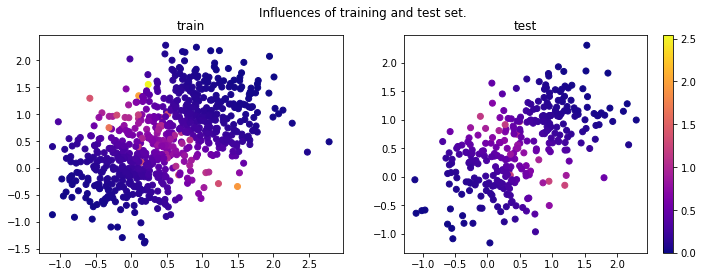

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig, ax = plt.subplots(1, num_datasets, figsize=(12, 4))
mean_influences = {
    'train': mean_train_influences,
    'test': mean_test_influences
}
v_max = max(np.max(mean_train_influences), np.max(mean_test_influences))
for i, dataset_name in enumerate(datasets.keys()):
    x = datasets[dataset_name][0].copy()
    ax[i].set_title(dataset_name)
    points = ax[i].scatter(x[:, 0], x[:, 1], c=mean_influences[dataset_name], vmin=0, vmax=v_max, cmap="plasma")

plt.suptitle("Influences of training and test set.")
plt.colorbar(points)
plt.show()

## Flipping 5% of the labels of the train set

We assume that our reference test set is not flipped and was checked, e.g. by human inspection. In comparison the test set gets flipped 5% at random positions. We want to show how to identify flipped examples 

In [88]:
flip_percentage = 0.05
flip_num_samples = int(flip_percentage * len(dataset.x_train))
idx = np.random.choice(len(dataset.x_train), replace=False, size=flip_num_samples)

In [89]:
flipped_dataset = Dataset(
    dataset.x_train.copy(),
    dataset.y_train.copy(),
    dataset.x_test.copy(),
    dataset.y_test.copy()
)
flipped_dataset.y_train[idx] = 1 - flipped_dataset.y_train[idx]

## Identifiying data points with absurd high gradients

In [90]:
flipped_train_test_influences = influences(
    model,
    flipped_dataset.x_train,
    flipped_dataset.y_train,
    flipped_dataset.x_test,
    flipped_dataset.y_test,
    influence_type=InfluenceTypes.Up
)

In [91]:
mean_flipped_train_test_influences = np.abs(np.mean(flipped_train_test_influences, axis=0))
estimated_idx = np.flip(np.argsort(mean_flipped_train_test_influences))[:len(idx)]

In [103]:
found_elements = set(estimated_idx).intersection(set(idx))
remaining_element = set(idx).difference(set(estimated_idx))
display(f"Around {100* len(found_elements) / len(idx):.2f} could be identified. But there are {100* len(remaining_element) / len(idx):.2f}% remaining samples")

'Around 82.86 could be identified. But there are 17.14% remaining elements'

As we can see it was very straightforward to identify 82% of the 5% flipped data samples. This accounts for at most 1% remaining flipped samples. We now want to take a look at these cases.

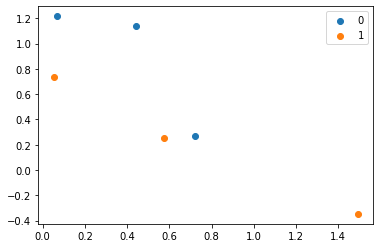

In [115]:
import matplotlib.pyplot as plt

remaining_idx = np.asarray(list(remaining_element), dtype=int)
plt.figure()
y = flipped_dataset.y_train[remaining_idx]
for v in np.unique(y):
    sub_idx = np.argwhere(y == v)
    c_idx = remaining_idx[sub_idx]
    plt.scatter(flipped_dataset.x_train[c_idx, 0], flipped_dataset.x_train[c_idx, 1], label=str(v))

plt.legend()
plt.show()